# NTU CSIE - Digital Visual Effects (2020 Spring)
# Project 1 - High Dynamic Range Imaging

## Environment Setup

In [1]:
import os
import pandas as pd
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
from time import time

## Load Images

In [2]:
df = pd.read_csv('../data/image_list.csv')
df = df.sort_values('exposure_time' , ascending = False)
images , exposure_times = [] , []
for image_name , exposure_time in zip(df['image_name'].values , df['exposure_time'].values):
    image = cv2.imread(os.path.join('../data/' , image_name) , cv2.IMREAD_COLOR)
    images.append(image)
    exposure_times.append(exposure_time)

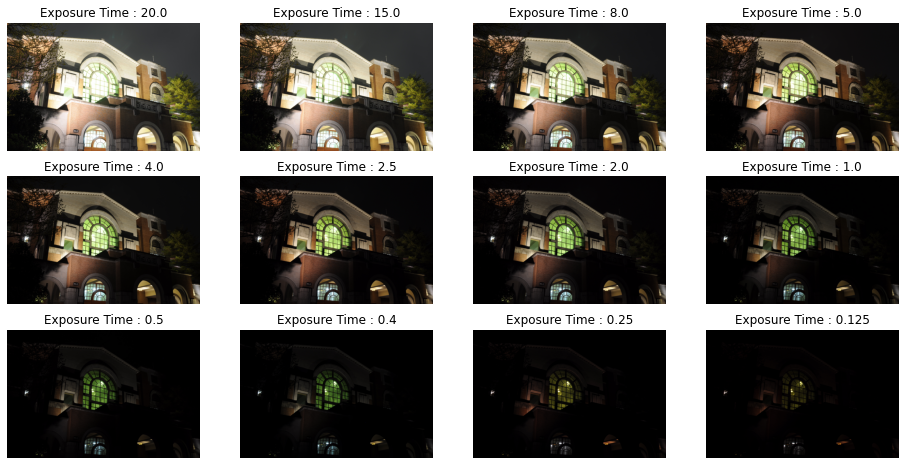

In [3]:
fig , axes = plt.subplots(math.ceil(len(images) / 4) , 4 , figsize = (16 , 8))
for i , (image , exposure_time) in enumerate(zip(images , exposure_times)):
    ax = axes[i // 4 , i % 4]
    ax.set_title(f'Exposure Time : {exposure_time}')
    ax.imshow(cv2.cvtColor(image , cv2.COLOR_BGR2RGB))
    ax.set_axis_off()
plt.show()

## Image Alignment

### Median Threshold Bitmap Alignment

In [4]:
class MTB:
    def __init__(self , max_offset = 0 , tolerance = 10):
        self.max_offset = max_offset
        self.max_depth = int(math.log2(max_offset + 1))
        self.tolerance = tolerance

    def get_bitmap_and_mask(self , image):
        threshold = np.median(image)
        bitmap = image <= threshold
        mask = np.logical_or(image < threshold - self.tolerance , image > threshold + self.tolerance)
        return bitmap , mask

    def shift(self , image , offset_x , offset_y):
        translation_matrix = np.array([[1.0 , 0.0 , offset_x] , [0.0 , 1.0 , offset_y]])
        return cv2.warpAffine(image.astype(np.uint8) , translation_matrix , (image.shape[1] , image.shape[0]))

    def count_difference(self , bitmap_1 , bitmap_2 , mask_1 , mask_2):
        return np.sum(np.logical_and(np.logical_and(np.logical_xor(bitmap_1 , bitmap_2) , mask_1) , mask_2))

    def find_best_offset(self , source , target , previous_offset_x = 0 , previous_offset_y = 0):
        bitmap_source , mask_source = self.get_bitmap_and_mask(source)
        bitmap_target , mask_target = self.get_bitmap_and_mask(target)
        min_difference , best_offset_x , best_offset_y = np.inf , None , None
        for offset_x in [-1 , 0 , 1]:
            for offset_y in [-1 , 0 , 1]:
                shifted_bitmap_source = self.shift(bitmap_source , previous_offset_x + offset_x , previous_offset_y + offset_y)
                shifted_mask_source = self.shift(mask_source , previous_offset_x + offset_x , previous_offset_y + offset_y)
                difference = self.count_difference(shifted_bitmap_source , bitmap_target , shifted_mask_source , mask_target)
                if difference < min_difference:
                    min_difference = difference
                    best_offset_x = previous_offset_x + offset_x
                    best_offset_y = previous_offset_y + offset_y
        return best_offset_x , best_offset_y

    def align_image(self , source , target , depth = None):
        if depth is None:
            depth = self.max_depth

        if depth == 0:
            offset_x , offset_y = 0 , 0
        else:
            previous_offset_x, previous_offset_y = self.align_image(cv2.pyrDown(source) , cv2.pyrDown(target) , depth - 1)
            offset_x , offset_y = self.find_best_offset(source , target , 2 * previous_offset_x , 2 * previous_offset_y)

        return offset_x , offset_y
    
    def align_images(self , images):
        target = cv2.cvtColor(images[0] , cv2.COLOR_BGR2GRAY)
        result , offset = [images[0]] , [(0 , 0)]
        for i in range(1 , len(images)):
            source = cv2.cvtColor(images[i] , cv2.COLOR_BGR2GRAY)
            offset_x , offset_y = self.align_image(source , target)
            result.append(self.shift(images[i] , offset_x , offset_y))
            offset.append((offset_x , offset_y))
        return result , offset

In [5]:
alignment_algorithm = MTB(max_offset = 16)
aligned_images , offset = alignment_algorithm.align_images(images)

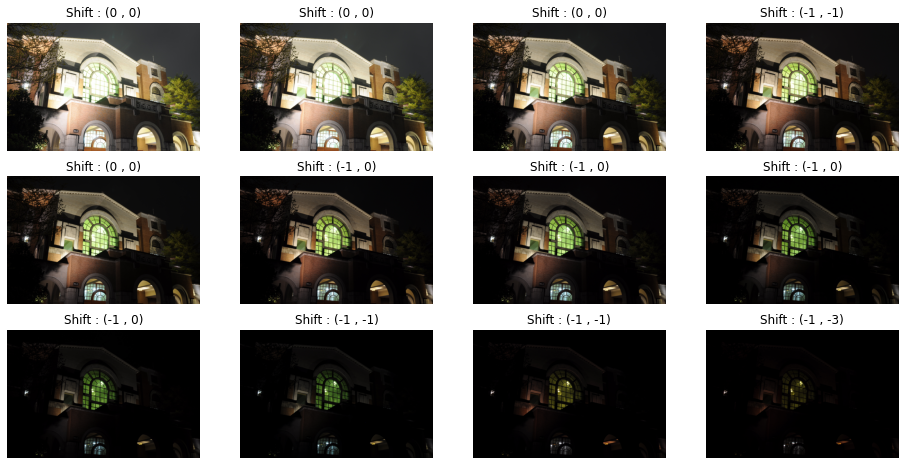

In [6]:
fig , axes = plt.subplots(math.ceil(len(images) / 4) , 4 , figsize = (16 , 8))
for i , (image , (offset_x , offset_y)) in enumerate(zip(aligned_images , offset)):
    ax = axes[i // 4 , i % 4]
    ax.set_title(f'Shift : ({offset_x} , {offset_y})')
    ax.imshow(cv2.cvtColor(image , cv2.COLOR_BGR2RGB))
    ax.set_axis_off()
plt.show()

## HDR Reconstruction

### Debevec

In [7]:
class Debevec:
    def __init__(self , number_of_sample_vertical = 10 , number_of_sample_horizontal = 10 , lambd = 10):
        self.number_of_sample_vertical = number_of_sample_vertical
        self.number_of_sample_horizontal = number_of_sample_horizontal
        self.number_of_sample = number_of_sample_vertical * number_of_sample_horizontal
        self.lambd = lambd
        self.weight = 127 - np.floor(np.abs(np.arange(256) - 127.5))

    def solve_response_curve(self , images , exposure_times):
        number_of_image = len(images)
        images = [cv2.resize(image , (self.number_of_sample_horizontal , self.number_of_sample_vertical) , cv2.INTER_NEAREST) for image in images]

        self.response_curves = []

        for i in range(3):
            A = np.zeros((number_of_image * self.number_of_sample + 255 , self.number_of_sample + 256))
            b = np.zeros((number_of_image * self.number_of_sample + 255))

            for j in range(number_of_image):
                for k in range(self.number_of_sample):
                    value = images[j][k // self.number_of_sample_horizontal][k % self.number_of_sample_horizontal][i]
                    A[j * self.number_of_sample + k][value] = self.weight[value] * 1
                    A[j * self.number_of_sample + k][k + 256] = self.weight[value] * -1
                    b[j * self.number_of_sample + k] = self.weight[value] * np.log(exposure_times[j])

            for j in range(254):
                A[number_of_image * self.number_of_sample + j][j] = self.lambd * self.weight[j + 1] * 1
                A[number_of_image * self.number_of_sample + j][j + 1] = self.lambd * self.weight[j + 1] * -2
                A[number_of_image * self.number_of_sample + j][j + 2] = self.lambd * self.weight[j + 1] * 1

            A[-1][127] = 1

            x = np.linalg.lstsq(A , b , rcond = None)[0]
            self.response_curves.append(x[ : 256])

    def reconstruct_HDR_image(self , images , exposure_times):
        HDR_image = np.zeros(images[0].shape)
        for i in range(3):
            HDR_image[ : , : , i] = np.exp(np.sum([np.array(list(map(lambda value : self.weight[value] * (self.response_curves[i][value] - np.log(exposure_time)) , image[ : , : , i]))) for image , exposure_time in zip(images , exposure_times)] , axis = 0) / \
                                          (np.sum([np.array(list(map(lambda value : self.weight[value] , image[ : , : , i]))) for image in images] , axis = 0) + 1e-8))
        return HDR_image.astype(np.float32)

In [8]:
HDR_algorithm = Debevec()
HDR_algorithm.solve_response_curve(images , exposure_times)
HDR_Debevec = HDR_algorithm.reconstruct_HDR_image(images , exposure_times)
cv2.imwrite('../data/HDR_Debevec.hdr' , HDR_Debevec)

True

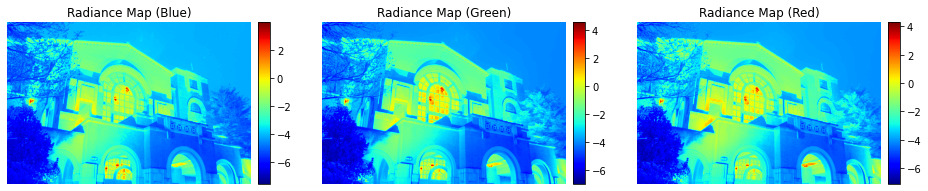

In [9]:
fig , axes = plt.subplots(1 , 3 , figsize = (16 , 4))
for i , channel in enumerate(['Blue' , 'Green' , 'Red']):
    ax = axes[i]
    ax.set_title(f'Radiance Map ({channel})')
    im = ax.imshow(np.log(HDR_Debevec[ : , : , i]) , cmap = 'jet')
    ax.set_axis_off()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right' , size = '5%' , pad = 0.1)
    fig.colorbar(im , cax = cax , orientation = 'vertical')
plt.show()

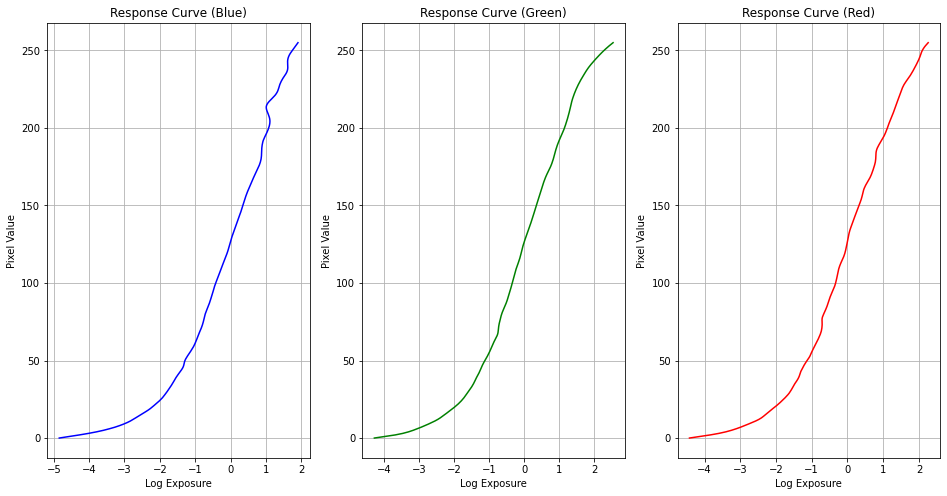

In [10]:
fig , axes = plt.subplots(1 , 3 , figsize = (16 , 8))
for i , channel in enumerate(['Blue' , 'Green' , 'Red']):
    ax = axes[i]
    ax.set_title(f'Response Curve ({channel})')
    ax.plot(HDR_algorithm.response_curves[i] , np.arange(256) , c = channel)
    ax.set_xlabel('Log Exposure')
    ax.set_ylabel('Pixel Value')
    ax.grid()
plt.show()

### Robertson

In [11]:
class Robertson:
    def __init__(self , iteration = 5):
        self.iteration = iteration
        self.weight = (np.exp(4) / (np.exp(4) - 1)) * np.exp(-(4 * np.arange(256) / 255 - 2)**2) + (1 / (1 - np.exp(4)))

    def solve_response_curve(self , images , exposure_times):
        number_of_image = len(images)
        height , width , _ = images[0].shape
        self.response_curves = []
        for i , channel in enumerate(['blue' , 'green' , 'red']):
            print(f'channel: {channel}')
            response_curve = np.arange(256) / 128
            for j in range(self.iteration):
                print(f'iteration: {j + 1} ' , end = '')
                start = time()

                radiance_map = np.sum([self.weight[image[ : , : , i]] * response_curve[image[ : , : , i]] * exposure_time for image , exposure_time in zip(images , exposure_times)] , axis = 0) / \
                               np.sum([self.weight[image[ : , : , i]] * exposure_time**2 for image , exposure_time in zip(images , exposure_times)] , axis = 0)
                
                response_curve = np.zeros((256))
                for k in range(256):
                    cardinality = 0
                    for image , exposure_time in zip(images , exposure_times):
                        response_curve[k] += np.sum(radiance_map[image[ : , : , i] == k] * exposure_time)
                        cardinality += np.sum(image[ : , : , i] == k)
                    response_curve[k] /= (cardinality + 1e-8)
                response_curve /= response_curve[128]

                error = np.sum([self.weight[image[ : , : , i]] * (response_curve[image[ : , : , i]] - radiance_map * exposure_time)**2 for image , exposure_time in zip(images , exposure_times)])
                end = time()
                print(f'({int(end - start)}s) error: {error}')

            self.response_curves.append(response_curve)

    def reconstruct_HDR_image(self , images , exposure_times):
        HDR_image = np.zeros(images[0].shape)
        for i in range(3):
            HDR_image[ : , : , i] = np.sum([self.weight[image[ : , : , i]] * self.response_curves[i][image[ : , : , i]] * exposure_time for image , exposure_time in zip(images , exposure_times)] , axis = 0) / \
                                    np.sum([self.weight[image[ : , : , i]] * exposure_time**2 for image , exposure_time in zip(images , exposure_times)] , axis = 0)
        return HDR_image.astype(np.float32)

In [12]:
HDR_algorithm = Robertson()
HDR_algorithm.solve_response_curve(images , exposure_times)
HDR_Robertson = HDR_algorithm.reconstruct_HDR_image(images , exposure_times)
cv2.imwrite('../data/HDR_Robertson.hdr' , HDR_Robertson)

channel: blue
iteration: 1 (18s) error: 225089.1853994518
iteration: 2 (18s) error: 64139.26484661179
iteration: 3 (18s) error: 49431.63509771198
iteration: 4 (18s) error: 47749.31899879394
iteration: 5 (18s) error: 47346.71256287769
channel: green
iteration: 1 (19s) error: 414227.1047264855
iteration: 2 (19s) error: 94448.97872959817
iteration: 3 (19s) error: 52651.31173709909
iteration: 4 (19s) error: 48451.72248366615
iteration: 5 (19s) error: 47872.56861505056
channel: red
iteration: 1 (19s) error: 581250.9893848725
iteration: 2 (18s) error: 114253.84574389736
iteration: 3 (19s) error: 75405.7449791593
iteration: 4 (19s) error: 72702.08341965136
iteration: 5 (19s) error: 72311.25150727865


True

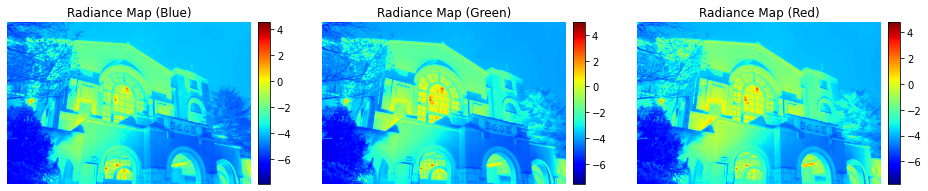

In [13]:
fig , axes = plt.subplots(1 , 3 , figsize = (16 , 4))
for i , channel in enumerate(['Blue' , 'Green' , 'Red']):
    ax = axes[i]
    ax.set_title(f'Radiance Map ({channel})')
    im = ax.imshow(np.log(HDR_Robertson[ : , : , i]) , cmap = 'jet')
    ax.set_axis_off()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right' , size = '5%' , pad = 0.1)
    fig.colorbar(im , cax = cax , orientation = 'vertical')
plt.show()

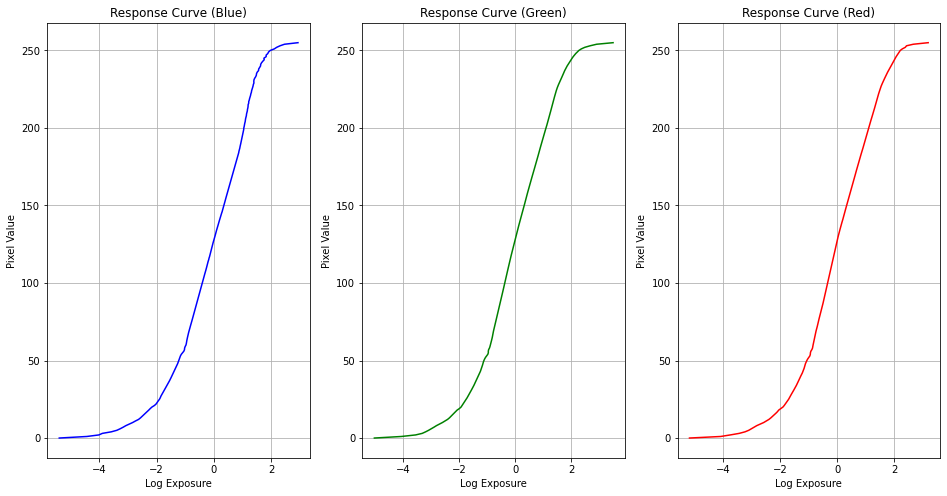

In [14]:
fig , axes = plt.subplots(1 , 3 , figsize = (16 , 8))
for i , channel in enumerate(['Blue' , 'Green' , 'Red']):
    ax = axes[i]
    ax.set_title(f'Response Curve ({channel})')
    ax.plot(np.log(HDR_algorithm.response_curves[i] + 1e-8) , np.arange(256) , c = channel)
    ax.set_xlabel('Log Exposure')
    ax.set_ylabel('Pixel Value')
    ax.grid()
plt.show()

## Tone Mapping

### Reinhard

In [15]:
def Reinhard_global(HDR_image , a = 0.18 , L_white = None):
    L_w = 0.06 * HDR_image[ : , : , 0] + 0.67 * HDR_image[ : , : , 1] + 0.27 * HDR_image[ : , : , 2]

    L_w_average = np.exp(np.mean(np.log(L_w + 1e-8)))
    L_m = a * L_w / L_w_average
    if L_white is None:
        L_white = np.max(L_m)
    L_d = L_m * (1 + L_m / L_white**2) / (1 + L_m)
    
    LDR_image = np.zeros(HDR_image.shape)
    for i in range(3):
        LDR_image[ : , : , i] = HDR_image[ : , : , i] / L_w * L_d

    LDR_image = np.clip(255 * LDR_image , 0 , 255).astype(np.uint8)
    return LDR_image

def Reinhard_local(HDR_image , a = 0.18 , phi = 8 , eps = 0.05):
    L_w = 0.06 * HDR_image[ : , : , 0] + 0.67 * HDR_image[ : , : , 1] + 0.27 * HDR_image[ : , : , 2]

    L_w_average = np.exp(np.mean(np.log(L_w + 1e-8)))
    L_m = a * L_w / L_w_average

    previous_L_blur = L_m
    L_d = np.zeros(L_m.shape)
    finish = np.full(L_m.shape , False)
    for scale in range(1 , 9):
        s_1 = 2 * math.ceil(1.6**(scale - 1) / math.sqrt(2)) + 1
        s_2 = 2 * math.ceil(1.6**scale / math.sqrt(2)) + 1
        L_blur_1 = cv2.GaussianBlur(L_m , (s_1 , s_1) , 0)
        L_blur_2 = cv2.GaussianBlur(L_m , (s_2 , s_2) , 0)
        V = (L_blur_1 - L_blur_2) / (2**phi * a / s_1**2 + L_blur_1)
        
        index = np.logical_and(V >= eps , np.logical_not(finish))
        L_d[index] = (L_m / (1 + previous_L_blur))[index]
        finish[index] = True
        
        previous_L_blur = L_blur_1
        
    index = np.logical_not(finish)
    L_d[index] = (L_m / (1 + previous_L_blur))[index]
    
    LDR_image = np.zeros(HDR_image.shape)
    for i in range(3):
        LDR_image[ : , : , i] = HDR_image[ : , : , i] / L_w * L_d

    LDR_image = np.clip(255 * LDR_image , 0 , 255).astype(np.uint8)
    return LDR_image

In [16]:
LDR_Debevec_global = Reinhard_global(HDR_Debevec)
cv2.imwrite('../data/LDR_Debevec_global.png' , LDR_Debevec_global)

LDR_Debevec_local = Reinhard_local(HDR_Debevec)
cv2.imwrite('../data/LDR_Debevec_local.png' , LDR_Debevec_local)

LDR_Robertson_global = Reinhard_global(HDR_Robertson)
cv2.imwrite('../data/LDR_Robertson_global.png' , LDR_Robertson_global)

LDR_Robertson_local = Reinhard_local(HDR_Robertson)
cv2.imwrite('../data/LDR_Robertson_local.png' , LDR_Robertson_local)

True

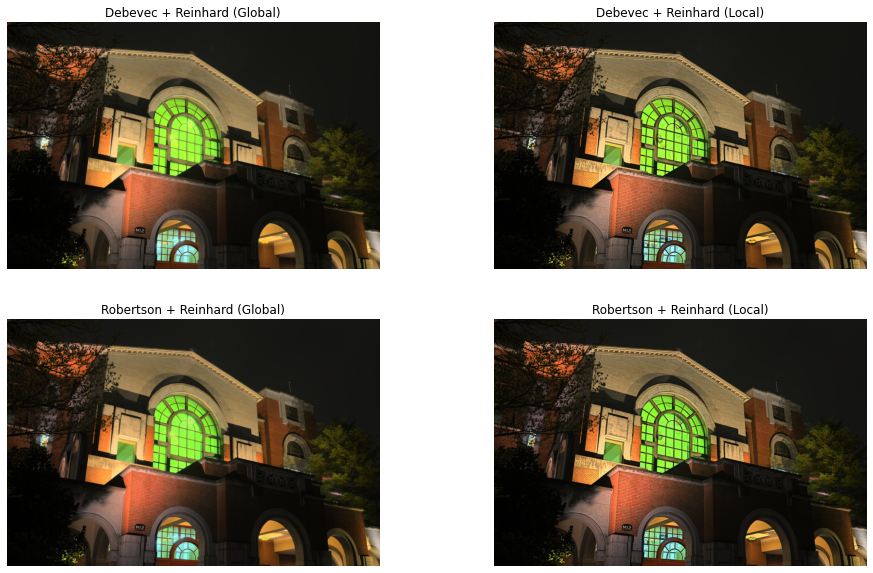

In [17]:
fig , axes = plt.subplots(2 , 2 , figsize = (16 , 10))

ax = axes[0 , 0]
ax.set_title('Debevec + Reinhard (Global)')
ax.imshow(cv2.cvtColor(LDR_Debevec_global , cv2.COLOR_BGR2RGB))
ax.set_axis_off()

ax = axes[0 , 1]
ax.set_title('Debevec + Reinhard (Local)')
ax.imshow(cv2.cvtColor(LDR_Debevec_local , cv2.COLOR_BGR2RGB))
ax.set_axis_off()

ax = axes[1 , 0]
ax.set_title('Robertson + Reinhard (Global)')
ax.imshow(cv2.cvtColor(LDR_Robertson_global , cv2.COLOR_BGR2RGB))
ax.set_axis_off()

ax = axes[1 , 1]
ax.set_title('Robertson + Reinhard (Local)')
ax.imshow(cv2.cvtColor(LDR_Robertson_local , cv2.COLOR_BGR2RGB))
ax.set_axis_off()

plt.show()

## OpenCV

In [18]:
calibrate_Debevec = cv2.createCalibrateDebevec()
response_curve_Debevec = calibrate_Debevec.process(np.array(images).copy() , times = np.array(exposure_times , dtype = np.float32).copy())
HDR_algorithm = cv2.createMergeDebevec()
HDR_Debevec = HDR_algorithm.process(np.array(images).copy() , times = np.array(exposure_times , dtype = np.float32).copy() , response = response_curve_Debevec)
cv2.imwrite('../data/HDR_Debevec_OpenCV.hdr' , HDR_Debevec)

True

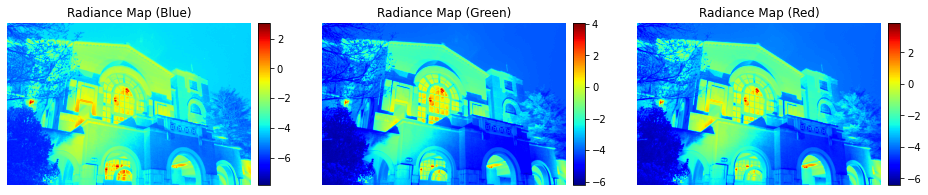

In [19]:
fig , axes = plt.subplots(1 , 3 , figsize = (16 , 4))
for i , channel in enumerate(['Blue' , 'Green' , 'Red']):
    ax = axes[i]
    ax.set_title(f'Radiance Map ({channel})')
    im = ax.imshow(np.log(HDR_Debevec[ : , : , i]) , cmap = 'jet')
    ax.set_axis_off()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right' , size = '5%' , pad = 0.1)
    fig.colorbar(im , cax = cax , orientation = 'vertical')
plt.show()

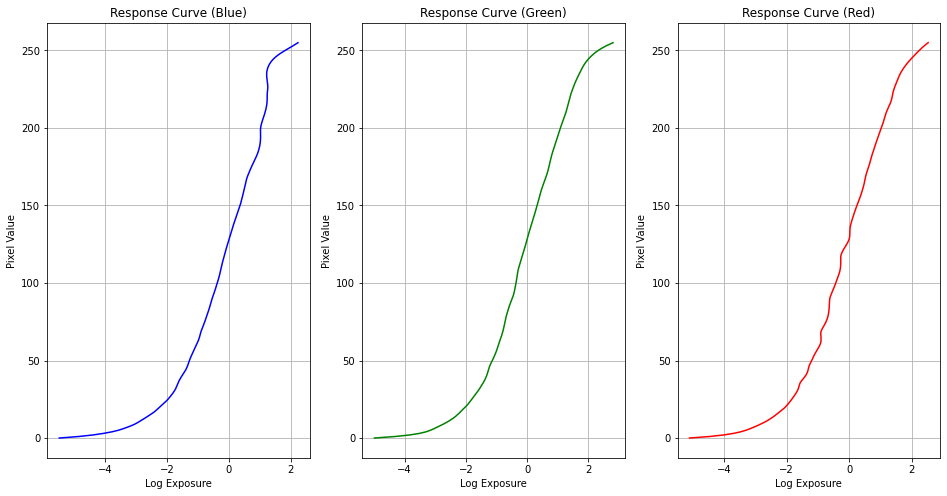

In [20]:
fig , axes = plt.subplots(1 , 3 , figsize = (16 , 8))
for i , channel in enumerate(['Blue' , 'Green' , 'Red']):
    ax = axes[i]
    ax.set_title(f'Response Curve ({channel})')
    ax.plot(np.log(response_curve_Debevec[ : , : , i].reshape(-1)) , np.arange(256) , c = channel)
    ax.set_xlabel('Log Exposure')
    ax.set_ylabel('Pixel Value')
    ax.grid()
plt.show()

In [21]:
calibrate_Robertson = cv2.createCalibrateRobertson()
response_curve_Robertson = calibrate_Robertson.process(np.array(images).copy() , times = np.array(exposure_times , dtype = np.float32).copy())
HDR_algorithm = cv2.createMergeRobertson()
HDR_Robertson = HDR_algorithm.process(np.array(images).copy() , times = np.array(exposure_times , dtype = np.float32).copy() , response = response_curve_Robertson)
cv2.imwrite('../data/HDR_Robertson_OpenCV.hdr' , HDR_Robertson)

True

/var/folders/85/vj50l3lj70z7c7w150vbq43w0000gn/T/ipykernel_59275/686910705.py:5: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(HDR_Robertson[ : , : , i]) , cmap = 'jet')


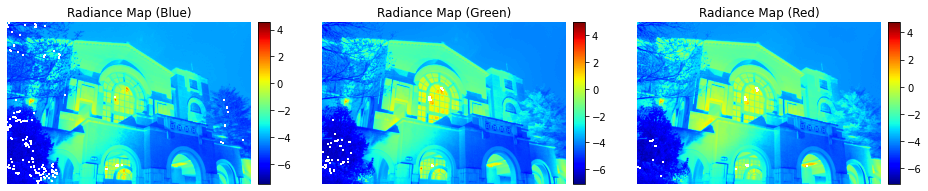

In [22]:
fig , axes = plt.subplots(1 , 3 , figsize = (16 , 4))
for i , channel in enumerate(['Blue' , 'Green' , 'Red']):
    ax = axes[i]
    ax.set_title(f'Radiance Map ({channel})')
    im = ax.imshow(np.log(HDR_Robertson[ : , : , i]) , cmap = 'jet')
    ax.set_axis_off()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right' , size = '5%' , pad = 0.1)
    fig.colorbar(im , cax = cax , orientation = 'vertical')
plt.show()

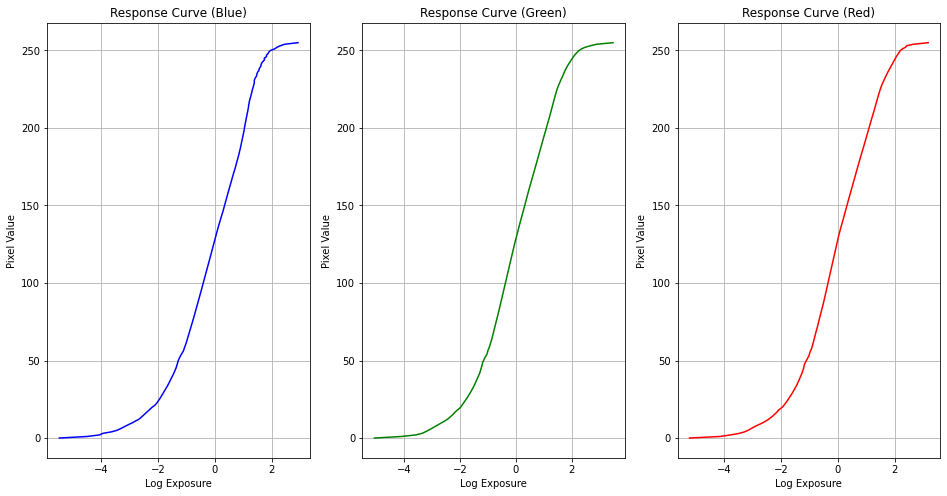

In [23]:
fig , axes = plt.subplots(1 , 3 , figsize = (16 , 8))
for i , channel in enumerate(['Blue' , 'Green' , 'Red']):
    ax = axes[i]
    ax.set_title(f'Response Curve ({channel})')
    ax.plot(np.log(response_curve_Robertson[ : , : , i].reshape(-1)) , np.arange(256) , c = channel)
    ax.set_xlabel('Log Exposure')
    ax.set_ylabel('Pixel Value')
    ax.grid()
plt.show()

In [24]:
tone_mapping_algorithm = cv2.createTonemapReinhard(1.5 , 0 , 0 , 0)

LDR_Debevec_global = tone_mapping_algorithm.process(HDR_Debevec.copy())
LDR_Debevec_global = np.clip(255 * LDR_Debevec_global , 0 , 255).astype(np.uint8)
cv2.imwrite('../data/LDR_Debevec_global_OpenCV.png' , LDR_Debevec_global)

LDR_Robertson_global = tone_mapping_algorithm.process(HDR_Robertson.copy())
LDR_Robertson_global = np.clip(255 * LDR_Robertson_global , 0 , 255).astype(np.uint8)
cv2.imwrite('../data/LDR_Robertson_global_OpenCV.png' , LDR_Robertson_global)

[ WARN:0] global /private/var/folders/b7/g6qfbypj0tq32j5_trjh516r0000gn/T/pip-req-build-td1cq9np/opencv/modules/core/src/matrix_expressions.cpp (1334) assign OpenCV/MatExpr: processing of multi-channel arrays might be changed in the future: https://github.com/opencv/opencv/issues/16739


True

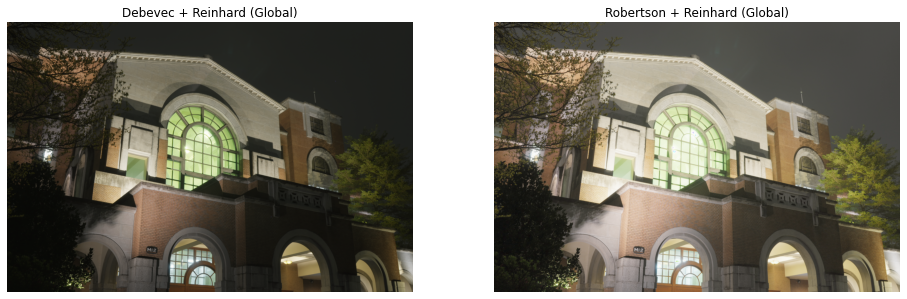

In [25]:
fig , axes = plt.subplots(1 , 2 , figsize = (16 , 6))

ax = axes[0]
ax.set_title('Debevec + Reinhard (Global)')
ax.imshow(cv2.cvtColor(LDR_Debevec_global , cv2.COLOR_BGR2RGB))
ax.set_axis_off()

ax = axes[1]
ax.set_title('Robertson + Reinhard (Global)')
ax.imshow(cv2.cvtColor(LDR_Robertson_global , cv2.COLOR_BGR2RGB))
ax.set_axis_off()

plt.show()